<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/5_9GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import time
import torchvision
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pyplot as plt
import torch.nn.functional as F
FILENAME ='/home/lp'
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')

In [16]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer,self).__init__()
  def forward(self,x):
    return x.view(x.shape[0],-1)
class GlobalAveragePool(nn.Module):
  def __init__(self):
    super(GlobalAveragePool,self).__init__()
  def forward(self,x):
    return F.avg_pool2d(x,kernel_size=x.size()[2:])

In [17]:
class Inception(nn.Module):
  def __init__(self,in_channel,c1,c2,c3,c4):
    super(Inception,self).__init__()
    self.p1 = nn.Sequential(
        nn.Conv2d(in_channel,c1,kernel_size=1),
        nn.ReLU()
        )
    self.p2 = nn.Sequential(
        nn.Conv2d(in_channel,c2[0],kernel_size=1),
        nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1),
        nn.ReLU()
    )
    self.p3 = nn.Sequential(
        nn.Conv2d(in_channel,c3[0],kernel_size=1),
        nn.Conv2d(c3[0],c3[1],kernel_size=5,stride=1,padding=2),
        nn.ReLU()
    )
    self.p4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_channel,c4,kernel_size=1),
        nn.ReLU()
    )
  def forward(self,x):
    p1 = self.p1(x)
    p2 = self.p2(x)
    p3 = self.p3(x)
    p4 = self.p4(x)
    return torch.cat((p1,p2,p3,p4),dim=1)

In [18]:
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)
b2 = nn.Sequential(
    nn.Conv2d(64,64,kernel_size=1),
    nn.Conv2d(64,192,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
)
b3 = nn.Sequential(
    Inception(192,64,(96,128),(16,32),32),
    Inception(256,128,(128,192),(32,96),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

)
b4 = nn.Sequential(
    Inception(480,192,(96,208),(16,48),64),
    Inception(512,160,(112,224),(24,64),64),
    Inception(512,128,(128,256),(24,64),64),
    Inception(512,112,(144,288),(32,64),64),
    Inception(528,256,(160,320),(32,128),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)
b5 = nn.Sequential(
    Inception(832,256,(160,320),(32,128),128),
    Inception(832,384,(192,384),(48,128),128),
    GlobalAveragePool()
)

In [19]:
net = nn.Sequential(b1,b2,b3,b4,b5,
          FlattenLayer(),
          nn.Linear(1024,10)
          )

In [ ]:
def load_data_fashion_mnist(batch_size,resize=None,root=FILENAME):
  trans =[]
  if resize:
    trans.append(transforms.Resize(size=resize))
  trans.append(transforms.ToTensor())
  transform = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=transform,download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False,transform=transform,download=True)
  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=2)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=2)
  return train_iter,test_iter
batch_size=128
train_iter,test_iter = load_data_fashion_mnist(batch_size,resize=96)

In [21]:
def evaculate_acuracy(data_iter,net,device):
  acc_sum=0.0
  n=0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net,nn.Module):
        acc_sum += (net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
      else:
        if ('is_training'in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1)==y).float().sum().cpu().item()
        else:
          acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n+=y.shape[0]
  return acc_sum/n

In [22]:
def train_ch5(net,train_iter,test_iter,batch_size,device,optimizer,num_epochs):
  loss =torch.nn.CrossEntropyLoss()
  net = net.to(device)
  print('training on:',device)
  for epoch in range(num_epochs):
    train_loss=0.0
    train_acc_sum = 0.0
    n = 0
    batch_cout=0
    start = time.time()
    for X,y in train_iter:
      X=X.to(device)
      y=y.to(device)
      y_hat=net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_loss +=l.cpu().item()
      train_acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n +=y.shape[0]
      batch_cout +=1
    test_acc_sum = evaculate_acuracy(test_iter,net,device)
    print('epoch:%d,loss:%.4f,train_acc:%.3f,test_acc:%.3f,time:%.1f'%(epoch+1,train_loss/batch_cout,train_acc_sum/n,test_acc_sum,time.time()-start))

In [23]:
lr = 0.001
num_epochs=5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,device,optimizer,num_epochs)

training on: cuda
epoch:1,loss:2.1956,train_acc:0.155,test_acc:0.513,time:207.7
epoch:2,loss:0.6613,train_acc:0.766,test_acc:0.804,time:207.1
epoch:3,loss:0.4271,train_acc:0.854,test_acc:0.858,time:207.1
epoch:4,loss:0.3567,train_acc:0.879,test_acc:0.881,time:207.7
epoch:5,loss:0.3155,train_acc:0.895,test_acc:0.878,time:207.7


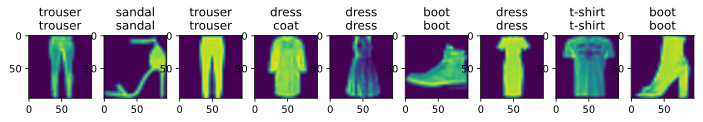

In [25]:
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','sneaker','bag','ankle','boot']
  return [text_labels[int(i)] for i in labels]
def show_fashion_mnist(images,labels):
  display.set_matplotlib_formats('svg')
  _,imgs = plt.subplots(1,len(images),figsize=(12,12))
  for img,figture,lbl in zip(imgs,images,labels):
    img.imshow(figture.view((96,96)).numpy())
    img.set_title(lbl)
    img.axes.get_xaxis().set_visible(True)
    img.axes.get_yaxis().set_visible(True)
  plt.show()
x,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(x.to(device)).argmax(dim=1).cpu().numpy())
title = [true+'\n'+pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(x[0:9],title[0:9])